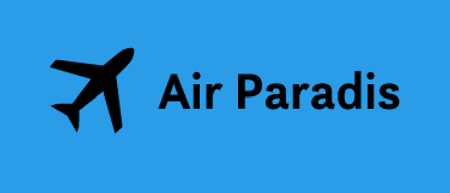

**Air Paradis** is an airline company that wants to use AI (*Artificial Intelligence*) to **detect Bad Buzz associated with its brand** in online public tweets.

**As AI engineer for Marketing Intelligence Consulting**, we will dive into **NLP** (*Natural Language Processing*) techniques to serve Air Paradis' purpose.

Indeed, NLP allows a machine to **understand and process human language**. Il nous aidera à résoudre cet **objectif de classification de texte** et à **détecter le sentiment** (positif ou négatif) de ces tweets.

Nous allons déployer notre meilleure solution **DETECT SENTIMENT** à travers la plateforme **Microsoft Azure Machine Learning** (***MS Azure ML***).

TODO :

- Réduire la taille du notebook au mieux avec plus d'automatisation et + factoriser.

Essayer :

- corriger les fautes d'orthographe ; la bibliothèque [*pyspellchecker*](https://pypi.org/project/pyspellchecker/).
- exclure toutes les lignes qui ne sont pas en anglais
- diviser / segmenter les mots dans le hashtag : comme #charitytuesday à convertir en *charity tuesday*

# Import des librairies et chargement des données

In [1]:
import dateutil, datetime

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import re
import contractions

import nltk
from nltk.tokenize.treebank import TreebankWordDetokenizer
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
nltk.download('stopwords')

from wordcloud import WordCloud, STOPWORDS

import spacy
import en_core_web_sm
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

from collections import Counter

[nltk_data] Downloading package stopwords to /home/reda/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Le projet ne fournis pas de donnée nous allons donc en récupéré via ce lien https://www.kaggle.com/datasets/kazanova/sentiment140.

- convertir la chaîne PDT (fuseau horaire US/Pacifique).

Voici les différentes colonnes de notre ressource :

- **target**: la polarité du tweet (0 = négatif, 2 = neutre, 4 = positif. Mais nous n'avons pas de sentiement = 2 dans notre jeux de données)

- **ids**: l'identifiant du tweet

- **date**: la date du tweet

- **flag**: la requête. S'il n'y a pas de requête, cette valeur est NO_QUERY.

- **user**: l'utilisateur qui a tweeté

- **text**: le texte du tweet

In [2]:
# Import original data and name columns
df = pd.read_csv('data/training.1600000.processed.noemoticon.csv',
                 encoding = 'ISO-8859-1',
                 # Nous précison le nom de chaque colonne car elles n'ont 
                 # pas d'en tête'
                 names=['sentiment', 'id', 'date', 'flag', 'user', 'tweet'])

# Supprime la colonne flag qui nous pensons ne sera pas util
del df["flag"]

In [3]:
df.head(2)

,sentiment,id,date,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,scotthamilton,is upset that he can't update his Facebook by ...


# Nettoyage des données

Nous savons que les tweet on été envoyés du 6 mai 2009 au 25 juin 2009. Nous pouvons supprimer la colonne date qui ne sera surement pas très utile.

In [4]:
del df['date']

Passons au valeurs manquantes.

In [5]:
df.isnull().values.any()

False

Nous n'avons aucune valeur manquante pour le moment. Passons aux doublons.

In [6]:
df.duplicated("tweet").values.any()

True

In [7]:
df[df.duplicated(subset=['user', 'tweet'])].sort_values("user")

,sentiment,id,user,tweet
999959,4,1879941003,007peter,"@NaniWaialeale No, not Keith Olbermann, he ann..."
995446,4,1835719548,007wisdom,'Time Is An Illusion and All Time Is Now'... &...
889033,4,1687496734,007wisdom,&quot;All that we are is the result of what we...
984036,4,1834348688,007wisdom,'Time Is An Illusion and All Time Is Now'... &...
953751,4,1824711167,007wisdom,'Time Is An Illusion and All Time Is Now'... &...
...,...,...,...,...
1579667,4,2189971294,zibbet,Learn how to 'Effectively Promote Your Shop' u...
1185965,4,1982872880,zoetunstall,@tommcfly Hey Tom whereabouts in Uganda did y...
942791,4,1794782830,zoezf,@enzopilarta kakaasar kasi eh! puro cliffhange...
1591551,4,2191582417,zombieite,packing :-| :-/ :-?


Seul les doublons sur les tweets sont vraiment important. Mais nous devons supprimer les doublons de tweet lorsqu'ils appartiennent au même utilisateur, pour ne pase supprimer deux même tweet que deux personnes auraient postés 

In [8]:
df.drop_duplicates(subset=['user', 'tweet'], inplace=True)
df[df.duplicated(subset=['user', 'tweet'])].sort_values("user")

,sentiment,id,user,tweet


## Séléction des données

Les tweet négatifs ont pour valeur "0" et "4" pour les tweets positifs.

Remplaçons ces valeurs pour les rendre un peu plus claires :

- 0 pour les tweets négatifs 

- 1 pour les tweets positifs.

In [9]:
df['sentiment'] = df['sentiment'].replace([0, 4],[0,1])

df.sentiment.value_counts()

0    798150
1    796595
Name: sentiment, dtype: int64

La target est plutôt equilibrée, mais nous allons quand même réduire la quantité de tweet positif pour être parfaitement aligné avec la quantité de tweet negatif.

In [10]:
negatif = list(df["sentiment"].value_counts())[0]
positif = list(df["sentiment"].value_counts())[1]

In [11]:
# Sentiment positif moins sentiment négatifs
difference = negatif - positif
# Prends des lignes positives aléatoirement
df_sentiment = df[df['sentiment'] == 0].sample(difference)
liste_sentiment = list(df_sentiment.index)

In [12]:
# Réaffecte la dataframme sans les lignes choisies aléatoirement
df = df[~df.index.isin(liste_sentiment)]
df.sentiment.value_counts()

0    796595
1    796595
Name: sentiment, dtype: int64

# Statistiques

## Nombre de mots

Voyons par curiosité si le nombre de mot à une influence sur le sentiment du tweet.

Quantité de mots pour les tweet positifs : min :1, max :64, mean :13
Quantité de mots pour les tweet negatifs : min :1, max :57, mean :14




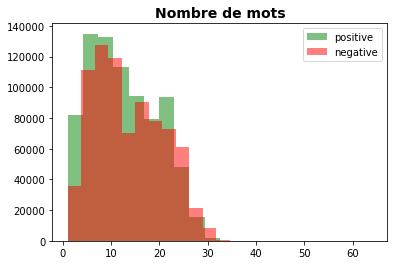

In [13]:
tweet_negatif = df[df.sentiment == 0]
tweet_positif = df[df.sentiment == 1]

# Compte le nombre de mot pour chaque texte négatifs et positifs
len_negatif = tweet_negatif.tweet.str.split().str.len()
len_positif = tweet_positif.tweet.str.split().str.len()

print('Quantité de mots pour les tweet positifs : min :{}, max :{}, mean :{}'.
      format(len_positif.min(), len_positif.max(),
             round(len_positif.mean())))
print('Quantité de mots pour les tweet negatifs : min :{}, max :{}, mean :{}'.
      format(len_negatif.min(), len_negatif.max(),
             round(len_negatif.mean())))
print('\n')

plt.figure()
plt.hist(len_positif, bins=20, label='positive', color='g', alpha=0.5)
plt.hist(len_negatif, bins=20, label='negative', color='r', alpha=0.5)
plt.title('Nombre de mots', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

La quantité de mot est à peu près similaire, il n'y a pas une diffèrence assez grande pour y porter attention pour l'instant.

### Nombre de mot par utilisateurs

Regardons rapidement si nous trouvons des utilisateurs postant plus souvent des avis négatifs que positifs et vice-versa.

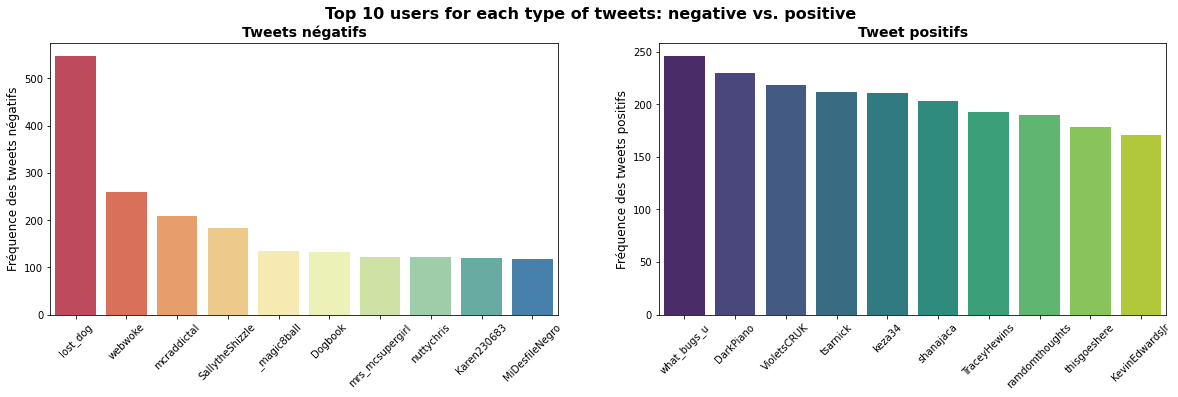

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))


negative_keywords = sns.barplot(
    # Place les noms d'utilisateur en abscisse
    x=tweet_negatif.user.value_counts()[:10].index, 
    # Place la quantité de tweets négatifs en ordonnée
    y=tweet_negatif.user.value_counts()[:10],
    palette='Spectral',
    ax=ax1)

negative_keywords.set_xticklabels(negative_keywords.get_xticklabels(),
                                  rotation=45)

negative_keywords.set_ylabel('Fréquence des tweets négatifs', fontsize=12)
ax1.set_title('Tweets négatifs', fontsize=14, fontweight='bold')



positive_keywords = sns.barplot(
    x=tweet_positif.user.value_counts()[:10].index,
    y=tweet_positif.user.value_counts()[:10],
    palette='viridis',
    ax=ax2)

positive_keywords.set_xticklabels(positive_keywords.get_xticklabels(),
                                  rotation=45)

positive_keywords.set_ylabel('Fréquence des tweets positifs', fontsize=12)
ax2.set_title('Tweet positifs', fontsize=14, fontweight='bold')

plt.suptitle('Top 10 users for each type of tweets: negative vs. positive',
             fontsize=16,
             fontweight='bold')
plt.show()

Nous pouvons largement dégager un top 3 des utilisateurs ayant posté le plus de tweets négatifs, et la même chose pour les tweets positifs.

In [15]:
pd.options.display.max_colwidth = 80
utilisateur_negatif_3 = tweet_negatif.user.value_counts()[:10].index[:3]
utilisateur_positif_3 = tweet_positif.user.value_counts()[:10].index[:3]

In [16]:
tweet_negatif = tweet_negatif[["user", "tweet"]]
tweet_positif = tweet_positif[["user", "tweet"]]

x = 1
for user in utilisateur_negatif_3:
    print("Numéro " + str(x))
    print(tweet_negatif[tweet_negatif.user == user].shape)
    print(tweet_negatif[tweet_negatif.user == user].head(5))
    print('\n')
    x += 1

Numéro 1
(548, 2)
           user                                                         tweet
43935  lost_dog           @NyleW I am lost. Please help me find a good home. 
45574  lost_dog          @SallyD I am lost. Please help me find a good home. 
46919  lost_dog      @zuppaholic I am lost. Please help me find a good home. 
50572  lost_dog  @JeanLevertHood I am lost. Please help me find a good home. 
50854  lost_dog     @irenerencsi I am lost. Please help me find a good home. 


Numéro 2
(260, 2)
           user                               tweet
363303  webwoke  auchh, drop by 1  (32)elitestv.com
366529  webwoke     auchh, drop by 1  (7)pedeee.com
366530  webwoke  auchh, drop by 1  (17)rumahabi.com
366597  webwoke   auchh, drop by 1  (18)twitter.com
366599  webwoke     auchh, drop by 1  (19)yehia.org


Numéro 3
(209, 2)
              user  \
78963  mcraddictal   
80895  mcraddictal   
81390  mcraddictal   
87542  mcraddictal   
88435  mcraddictal   

                             

L'utilisateur "lost_dog" est assez étrange, ils a envoyer les mêmes messages plusieurs fois en disant qu'il était perdu d'où sont pseudo "lost_dog".

Peut être un simple spammeur ou un bot, tout comme l'utilisateur "webwoke" d'ailleurs.

In [17]:
x = 1
for user in utilisateur_positif_3:
    print("Numéro " + str(x))
    print(tweet_positif[tweet_positif.user == user].shape)
    print(tweet_positif[tweet_positif.user == user].head(5))
    print('\n')
    x += 1

Numéro 1
(246, 2)
                user  \
1141441  what_bugs_u   
1141626  what_bugs_u   
1141648  what_bugs_u   
1141674  what_bugs_u   
1142667  what_bugs_u   

                                                                                   tweet  
1141441  @JadeMcCray why limit your story to 140 chr. Tell all what is annoying you a...  
1141626  @cadmiumcannibal why limit your story to 140 ch. Tell all what is annoying y...  
1141648  @RonanDosSantos why limit your story to 140 chr. Tell all what is annoying y...  
1141674  @ShayMac28 why limit your story to 140 chr. Tell all what is annoying you at...  
1142667  @lynnsdecor why limit your story to 140 chr. Tell all what is annoying you a...  


Numéro 2
(230, 2)
             user  \
806955  DarkPiano   
819909  DarkPiano   
821696  DarkPiano   
831789  DarkPiano   
832252  DarkPiano   

                                                                                  tweet  
806955                                                

L'utilisateur "what_bugs_u" doit aussi être un spammeur ou un bot.

L'analyse des top utilisateurs sur chacun des sentiments est intéressant, nous devons garder à l'esprit qu'il **peut y avoir des robots** pouvant fausser nos interpration ainsi que l'entrainement de nos futur modèle.

Nous conserverons tout ça pour le moment.

Il pourrait être intéressant de regarder si les différents hashtag ont une influence sur le sentiment d'un tweet.

## Hashtags

In [18]:
# Nous récupérons les hashtag avec regex
def extract_hashtag(text):
    # #\S+ récupère les lettres allant du "#" au prochain espace
    pattern = r'#\S+'
    text = text.lower()
    # place le hashtag dans la liste (il peut y en avoir 0 comme plusieurs)
    liste_hashtag = re.findall(pattern, text)
    # return le ou les hashtags dans la même ligne que le tweet dans la
    for hashtag in liste_hashtag:
        return hashtag

In [19]:
df['hashtag'] = df['tweet'].apply(extract_hashtag)
df.head()

,sentiment,id,user,tweet,hashtag
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda g...",None
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as...,None
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go ...,None
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,None
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? becau...",None


Listons nos hashtag.

In [20]:
# Créer une liste de hashtag
hashtag = df['hashtag'].values.tolist()

In [21]:
# Comptez chaque hashtag unique
hashtag_quantite = Counter(hashtag)

In [22]:
# Afficher les 30 hashtags les plus courants
hashtag_quantite.most_common(30)

[(None, 1557198),
 ('#followfriday', 2214),
 ('#fb', 1704),
 ('#squarespace', 820),
 ('#ff', 774),
 ('#iranelection', 430),
 ('#musicmonday', 386),
 ('#1', 373),
 ('#asot400', 322),
 ('#iremember', 284),
 ('#myweakness', 258),
 ('#iphone', 244),
 ('#fail', 237),
 ('#f1', 234),
 ('#bgt', 231),
 ('#e3', 218),
 ('#bsb', 213),
 ('#2', 188),
 ('#inaperfectworld', 171),
 ('#haveyouever', 165),
 ('#spymaster', 148),
 ('#followfriday!', 139),
 ('#andyhurleyday', 130),
 ('#goodsex', 118),
 ('#tcot', 102),
 ('#dontyouhate', 101),
 ('#mmwanted', 100),
 ('#clothdiapers', 100),
 ('#hhrs', 95),
 ('#xboxe3', 94)]

Les hashtags n'ont pas l'air d'être utile pour détécter si un tweet est négatifs ou positif, nous mettons allons donc supprimer cette colonne.

In [23]:
df = df.drop(columns=['hashtag'])

# Preprocessing

Dans cette section, nous allons créer une série de fonctions de prétraitement, pour nettoyer les tweets et les rendre plus lisibles.

Nous allons effectuer les étapes suivantes :

- Normaliser le texte en minuscules ;
- Corriger certaines fautes d'orthographe que nous avons détectées ;
- Supprimer (ou remplacer) toutes les mentions d'utilisateurs, urls, hyperliens, emails et hashtags ;
- Supprimer (ou remplacer) certains caractères spécifiques ;
- Développer toutes les contractions anglaises pour conserver le sens et notamment le mot " not " qui pourrait être essentiel pour détecter un sentiment négatif ;
- Supprimer les chiffres et les caractères spéciaux ;
- Supprimer les ponctuations ;
- Supprimer les espaces blancs.

Nous allons avant cela créer une nouvelle colonne de manière à avoir d'un côté les tweet originaux et de l'autre les tweets traités.

In [24]:
df['tweet_traite'] = df['tweet'].copy()

df.head()

,sentiment,id,user,tweet,tweet_traite
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda g...","@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda g..."
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as...,is upset that he can't update his Facebook by texting it... and might cry as...
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go ...,@Kenichan I dived many times for the ball. Managed to save 50% The rest go ...
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? becau...","@nationwideclass no, it's not behaving at all. i'm mad. why am i here? becau..."


In [25]:
# Nous allons supprimer renommer les mot en abrégés
# Les espaces sont là pour évité de modifier la lettre dans un mot
# exemple : pour 'u : 'you' alors 'user' va devenir 'youser'
dict_abrege = {
    'omg': 'god',
    'gosh': 'god',
    'its': 'it is',
    'idk': 'i do not know',
    'your welcome': 'you are welcome',
    'bday': 'birthday',
    ' ur ': ' your ',
    ' til ': ' until ',
    'shoulda': 'should',
    'fb': 'facebook',
    'thx': 'thanks',
    ' yur ': ' your ',
    ' u ': ' you '
}

In [26]:
# Le tokenizer prends en compte les hashtag et les emojis dans la séparation
# des caractères
tknzr = TweetTokenizer()

def contraction(tweet):
    """
    Les contractions en anglais sont les "I'm" pour "I am", "It's" pour
    "It is". Nous allons donc remplacer les contractions pour avoir le 
    pronom et le verbe bien distinct
    """
    tweet = contractions.fix(tweet)
    return tweet

def traitement_tweet(tweet):
    """
    Cette fonction permet le traitement des textes de toutes la colonne
    sans boucle sur la dataframe.
    
    case=True/False --> sensibilité au majuscule et minuscule
    """
    # Convertis le tweet en minuscules
    tweet = tweet.str.lower()

    # Suppression des caractères échappés de Twitter (guillemets, esperluettes,
    # acronymes, émoticônes...)
    tweet = tweet.str.replace('&quot|&amp;|&gt;|&lt;', '')

    # Supprimer les URLs standards (commençant par http, https ou www)
    tweet = tweet.str.replace(r'http\S+|https\S+| www.\S+', 'url', case=False)

    # Supprimez les autres hyperliens (se terminant par .com, .org ou .net).
    tweet = tweet.str.replace(r'\S+\.com|\S+\.org|\S+\.net', 'url', case=False)

    # Remplacer toutes les mentions @ par users et # par hashtags
    tweet = tweet.str.replace(r'@[\w]*', 'user', case=False)
    tweet = tweet.str.replace(r'\#+[\w_]+[\w\'_\-]*[\w_]+', 'hashtag')

    # Supprime les réaction qui ne sont pas dans le dictionnaire
    tweet = tweet.str.replace(
        'lol|oh |haha|blah|ahh|aww|wow|yeah|yay|hmm|wtf|grr', '')
    
    # Replace "-" et " ' " par un espace
    tweet = tweet.str.replace("-|'", ' ')
    
    # Supprime tous les caractères numériques et spécial
    tweet = tweet.str.replace(r'[^a-zA-Z\s]', ' ')
    
    # Supprime la ponctuation
    tweet = tweet.str.replace(r'[^\w\s]+', '')

    # Corrige les mot en abrégé
    for key in dict_abrege.keys():
        tweet = tweet.str.replace(key, dict_abrege[key], case=True)

    return tweet

In [27]:
%%time
df['tweet_traite'] = df['tweet_traite'].apply(contraction)
df['tweet_traite'] = traitement_tweet(df['tweet_traite'])
df.head()

/tmp/ipykernel_7787/1335230129.py:26: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet = tweet.str.replace('&quot|&amp;|&gt;|&lt;', '')
/tmp/ipykernel_7787/1335230129.py:29: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet = tweet.str.replace(r'http\S+|https\S+| www.\S+', 'url', case=False)
/tmp/ipykernel_7787/1335230129.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet = tweet.str.replace(r'\S+\.com|\S+\.org|\S+\.net', 'url', case=False)
/tmp/ipykernel_7787/1335230129.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet = tweet.str.replace(r'@[\w]*', 'user', case=False)
/tmp/ipykernel_7787/1335230129.py:36: FutureWarning: The default value of regex will change from True to False in a future version.
  tweet = tweet.str.replace(r'\#+[\w_]+[\w\'_\-]*[\w_]+', 'hashtag')


CPU times: user 51.9 s, sys: 507 ms, total: 52.4 s
Wall time: 52.4 s


,sentiment,id,user,tweet,tweet_traite
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda g...",user url w that is a bummer you should got david carr of third day to d...
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as...,is upset that he cannot update his facebook by texting it and might cry a...
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go ...,user i dived many times for the ball managed to save the rest go out o...
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? becau...",user no it is not behaving at all i am mad why am i here because i canno...


Nous allons créer deux nouvelles colonnes :
- Une colonne qui aura le nombre des mots du tweet
- Une colonne qui aura lle nombre de l'ensemble des caractères du tweet

In [28]:
df['nombre_mot_traite'] = df['tweet_traite'].str.split().str.len()
df['nombre_caractere'] = df['tweet_traite'].str.len()

min_mot = df.nombre_mot_traite.min()
max_mot = df.nombre_mot_traite.max()

min_caractere = df.nombre_caractere.min()
max_caractere = df.nombre_caractere.max()

print('Min mot: {}, Max mot: {}'.format(min_mot, max_mot))
print('Min caractere: {}, Max caractere: {}'.format(min_caractere,
                                                    max_caractere))

df.head()

Min mot: 0, Max mot: 52
Min caractere: 1, Max caractere: 366


,sentiment,id,user,tweet,tweet_traite,nombre_mot_traite,nombre_caractere
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda g...",user url w that is a bummer you should got david carr of third day to d...,19,84
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as...,is upset that he cannot update his facebook by texting it and might cry a...,20,108
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go ...,user i dived many times for the ball managed to save the rest go out o...,17,84
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,49
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? becau...",user no it is not behaving at all i am mad why am i here because i canno...,23,102


In [29]:
df[df["nombre_mot_traite"] == 0].head(3)

,sentiment,id,user,tweet,tweet_traite,nombre_mot_traite,nombre_caractere
19010,0,1556750760,katiekorver,"haha yeah,",,0,3
55002,0,1684925125,abel209,yeah.... &gt;:-/,,0,10
69996,0,1693505285,jennyconfetti,Wow....,,0,5


In [30]:
df[df["nombre_caractere"] == 1].head(3)

,sentiment,id,user,tweet,tweet_traite,nombre_mot_traite,nombre_caractere
1470267,1,2065026452,Heatherlynne508,Oh yeah,,0,1


Au vu du traitement que nous avions fait sur les tweets, il est normal que des tweets ne se retrouve plus dans la colonne des tweets traités.

Nous allons garder seulement les tweet ayant plus d'un mot, les autres ne seront pas utils.

In [31]:
df.shape[0]

1593190

In [32]:
x = df.shape[0]
df = df[(df.nombre_mot_traite > 1)]
y = df.shape[0]
suppression_ligne = x-y
print('{} ligne(s) on été supprimée(s)'.format(suppression_ligne))
df.head()

7669 ligne(s) on été supprimée(s)


,sentiment,id,user,tweet,tweet_traite,nombre_mot_traite,nombre_caractere
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda g...",user url w that is a bummer you should got david carr of third day to d...,19,84
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as...,is upset that he cannot update his facebook by texting it and might cry a...,20,108
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go ...,user i dived many times for the ball managed to save the rest go out o...,17,84
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,49
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? becau...",user no it is not behaving at all i am mad why am i here because i canno...,23,102


Vérifions si nous avons obtenus de nouveaux doublons.

In [33]:
df[df.duplicated(subset=['user', 'tweet_traite'])]

,sentiment,id,user,tweet,tweet_traite,nombre_mot_traite,nombre_caractere
2775,0,1468448691,jaybe81,cannot upload my pic,cannot upload my pic,4,21
8658,0,1548306694,ctran08,@IAMtheCOMMODORE You guys should do your acostic performance at 5! I have a ...,user you guys should do your acostic performance at i have a championship...,22,127
8669,0,1548309386,ctran08,@theroser You guys should do your acostic performance at 5! I have a champio...,user you guys should do your acostic performance at i have a championship...,22,127
8683,0,1548312053,ctran08,@ThePISTOL You guys should do your acostic performance at 5! I have a champi...,user you guys should do your acostic performance at i have a championship...,22,127
9562,0,1548797393,tweetpet,@chromachris Clean Me!,user clean me,3,15
...,...,...,...,...,...,...,...
1595424,1,2192375508,sachiotaku,Thanks for the add @eiram03 http://plurk.com/p/11dl55,thanks for the add user url,6,28
1597953,1,2193055320,jgel717,@emmyrossum go out with me..,user go out with me,5,22
1597957,1,2193055582,NickkkJonasss,@Karen120374 I love you too,user i love you too,5,20
1598293,1,2193153131,SongoftheOss,Thanks to @storylet @ShinylVinyl @shanti45 for the props and blips â« http...,thanks to user user user for the props and blips url,11,57


Nous allons supprimer les nouveaux doublons.

In [34]:
x = df.shape[0]
df.drop_duplicates(subset=['user', 'tweet_traite'], inplace=True)
y = df.shape[0]
suppression_ligne = x-y
print('{} ligne(s) on été supprimée(s)'.format(suppression_ligne))
df.head()

5985 ligne(s) on été supprimée(s)


,sentiment,id,user,tweet,tweet_traite,nombre_mot_traite,nombre_caractere
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda g...",user url w that is a bummer you should got david carr of third day to d...,19,84
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as...,is upset that he cannot update his facebook by texting it and might cry a...,20,108
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go ...,user i dived many times for the ball managed to save the rest go out o...,17,84
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,49
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? becau...",user no it is not behaving at all i am mad why am i here because i canno...,23,102


In [35]:
# Nous mettons à jours les quantités max, min des mots et nous ajoutons 
# leurs moyennes
min_mot = df.nombre_mot_traite.min()
max_mot = df.nombre_mot_traite.max()
moyenne_mot = df.nombre_mot_traite.mean()

min_caractere = df.nombre_caractere.min()
max_caractere = df.nombre_caractere.max()
moyenne_caractere = df.nombre_caractere.mean()

Min mot: 2, Max mot: 52
Min caractere: 6, Max caractere: 365


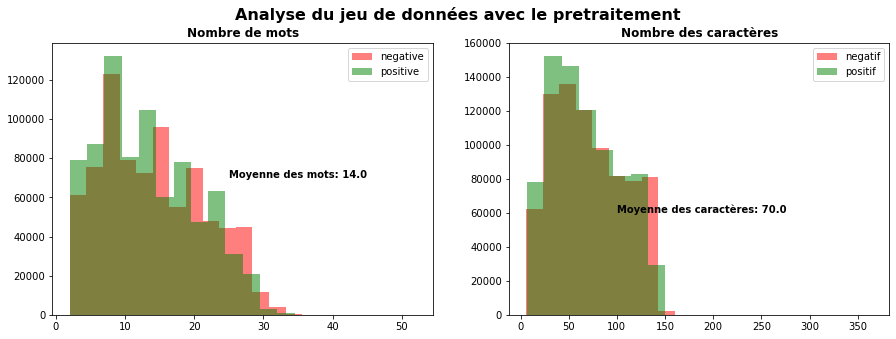

In [36]:
# Assigne les mots négatifs et positifs à une variable
mot_negatif = df[df.sentiment == 0]
mot_positif = df[df.sentiment == 1]

# Prepare plot variables
nombre_mot_negatif = mot_negatif["nombre_mot_traite"]
nombre_mot_positif = mot_positif["nombre_mot_traite"]
nombre_caractere_negatif = mot_negatif["nombre_caractere"]
nombre_caractere_positif = mot_positif["nombre_caractere"]

print('Min mot: {}, Max mot: {}'.format(min_mot, max_mot))
print('Min caractere: {}, Max caractere: {}'.format(min_caractere, max_caractere))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(nombre_mot_negatif, bins=20, label='negative', color='r', alpha=0.5)
ax1.hist(nombre_mot_positif, bins=20, label='positive', color='g', alpha=0.5)
ax1.set_title('Nombre de mots', fontsize=12, fontweight='bold')
message1 = 'Moyenne des mots: {}'.format(round(moyenne_mot, 0))
ax1.text(25, 70000, message1, weight='bold')
ax1.legend()

ax2.hist(nombre_caractere_negatif, bins=20, label='negatif', color='r', alpha=0.5)
ax2.hist(nombre_caractere_positif, bins=20, label='positif', color='g', alpha=0.5)
ax2.set_title('Nombre des caractères', fontsize=12, fontweight='bold')
message2 = 'Moyenne des caractères: {}'.format(round(moyenne_caractere, 0))
ax2.text(100, 60000, message2, weight='bold')
ax2.legend()

plt.suptitle('Analyse du jeu de données avec le pretraitement',
             fontsize=16, fontweight='bold')
plt.show()

Mettons à jours notre dataframe en supprimant la colonne du nombre des caractères qui nous pensons ne servira pas vraiment.

In [37]:
# Drop useless features
df.drop(columns=['nombre_caractere'], inplace=True)

In [38]:
df.head()

,sentiment,id,user,tweet,tweet_traite,nombre_mot_traite
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda g...",user url w that is a bummer you should got david carr of third day to d...,19
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as...,is upset that he cannot update his facebook by texting it and might cry a...,20
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go ...,user i dived many times for the ball managed to save the rest go out o...,17
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? becau...",user no it is not behaving at all i am mad why am i here because i canno...,23


## Stopwords et lemmatisation

In [39]:
# Initisalisation du stopwords
stop_words = stopwords.words('english')
stop_words.extend(["could", "might", "should", "us", "would",
                   "bit", "from", "re"])

# Nous ne voulons pas que ces deux mots soient supprimés, ils peuvent
# donner une indication sur le caractère positif ou négatif du tweet
stop_words.remove("not")
stop_words.remove("no")

print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very',

In [40]:
def supprimer_stopwords(tweet):

    tweet = tweet.apply(lambda x: ' '.join(
        [mot for mot in x.split() if mot not in (stop_words)]))

    return tweet

def lemmatisation(tweet):
    doc = nlp(tweet)
    tweet = " ".join([token.lemma_ for token in doc])

    return tweet


def supprime_lettre_seul(df, colonne):
    df[colonne] = df[colonne].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')
    return df

In [41]:
df['tweet_pas_stopwords'] = supprimer_stopwords(df['tweet_traite'])

df.head()

,sentiment,id,user,tweet,tweet_traite,nombre_mot_traite,tweet_pas_stopwords
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda g...",user url w that is a bummer you should got david carr of third day to d...,19,user url w bummer got david carr third day
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as...,is upset that he cannot update his facebook by texting it and might cry a...,20,upset cannot update facebook texting cry result school today also
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go ...,user i dived many times for the ball managed to save the rest go out o...,17,user dived many times ball managed save rest go bounds
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,whole body feels itchy like fire
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? becau...",user no it is not behaving at all i am mad why am i here because i canno...,23,user no not behaving mad cannot see


Nous allons lemmatiser nos tweet qui consiste à rendre au mot sa forme canonique, par exemple « building » deviendra « build ».

In [42]:
# %%time
# # Lemmatise les tweets de la colonne 'tweet_pas_stopwords' dans une nouvelle colonne
# df["tweet_lemma"] = df['tweet_pas_stopwords'].apply(lambda x: lemmatisation(x))

L'execution de la précédente cellule étant très longue (1h10), nous allons exporter la dataframe sous csv et réduire le temps d'execution du notebook pour le développement.

Le fichier csv aura donc l'étape de la lemmatisation que nous n'aurons plus besoin de faire.

In [43]:
# df.to_csv("data/df_preprocessing.csv",index=False)
df = pd.read_csv("data/df_preprocessing.csv")

In [44]:
# Nous supprimons maintenant les lettres seules du tweet
df = supprime_lettre_seul(df, "tweet_lemma")

/tmp/ipykernel_7787/4089083555.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  df[colonne] = df[colonne].str.replace(r'\b\w\b', '').str.replace(r'\s+', ' ')


In [45]:
df.head()

,sentiment,id,user,tweet,tweet_traite,nombre_mot_traite,tweet_pas_stopwords,tweet_lemma
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda g...",user url w that is a bummer you should got david carr of third day to d...,19,user url w bummer got david carr third day,user url bummer get david carr third day
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as...,is upset that he cannot update his facebook by texting it and might cry a...,20,upset cannot update facebook texting cry result school today also,upset can not update facebook texting cry result school today also
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go ...,user i dived many times for the ball managed to save the rest go out o...,17,user dived many times ball managed save rest go bounds,user dive many time ball manage save rest go bound
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,whole body feels itchy like fire,whole body feel itchy like fire
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? becau...",user no it is not behaving at all i am mad why am i here because i canno...,23,user no not behaving mad cannot see,user no not behave mad can not see


## Suppression doublons/mots minimum après préprocessing

Nous mettons à jours les quantités max, min des mots et nous ajoutons leurs moyennes

In [46]:
df['nombre_mot_lemma'] = df['tweet_lemma'].str.split().str.len()
df['nombre_caractere_lemma'] = df['tweet_lemma'].str.len()


min_mot = df.nombre_mot_lemma.min()
max_mot = df.nombre_mot_lemma.max()
moyenne_mot = df.nombre_mot_lemma.mean()

min_caractere = df.nombre_caractere_lemma.min()
max_caractere = df.nombre_caractere_lemma.max()
moyenne_caractere = df.nombre_caractere_lemma.mean()

Encore une fois, nous n'allons garder que les tweet ayant plus d'un mot.

In [47]:
x = df.shape[0]
df = df[(df.nombre_mot_lemma > 1)]
y = df.shape[0]
suppression_ligne = x-y
print('{} ligne(s) on été supprimée(s)'.format(suppression_ligne))
df.head()

17536 ligne(s) on été supprimée(s)


,sentiment,id,user,tweet,tweet_traite,nombre_mot_traite,tweet_pas_stopwords,tweet_lemma,nombre_mot_lemma,nombre_caractere_lemma
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda g...",user url w that is a bummer you should got david carr of third day to d...,19,user url w bummer got david carr third day,user url bummer get david carr third day,8.0,40.0
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as...,is upset that he cannot update his facebook by texting it and might cry a...,20,upset cannot update facebook texting cry result school today also,upset can not update facebook texting cry result school today also,11.0,66.0
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go ...,user i dived many times for the ball managed to save the rest go out o...,17,user dived many times ball managed save rest go bounds,user dive many time ball manage save rest go bound,10.0,50.0
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,whole body feels itchy like fire,whole body feel itchy like fire,6.0,31.0
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? becau...",user no it is not behaving at all i am mad why am i here because i canno...,23,user no not behaving mad cannot see,user no not behave mad can not see,8.0,34.0


Verifions si nous avons obtenus de nouveau doublons.

In [48]:
df[df.duplicated(subset=['user', 'tweet_lemma'])]

,sentiment,id,user,tweet,tweet_traite,nombre_mot_traite,tweet_pas_stopwords,tweet_lemma,nombre_mot_lemma,nombre_caractere_lemma
121,0,1467839816,viviana09,wednesday my b-day n don't know what 2 do!,wednesday my b day n do not know what do,10,wednesday b day n not know,wednesday day not know,4.0,22.0
199,0,1467861413,AmyJade,couldn't get shit done today ~ i'm so screwed,could not get shit done today i am so screwed,10,not get shit done today screwed,not get shit do today screw,6.0,27.0
251,0,1467875930,gregcronin,missed Brent at praise band. No fun to not have your lead guitarist. &lt;po...,missed brent at praise band no fun to not have your lead guitarist pout,14,missed brent praise band no fun not lead guitarist pout,miss brent praise band no fun not lead guitarist pout,10.0,53.0
1524,0,1468174365,supclayyy,"really now, time for sleep. dreaming of my city, more tattoos, and other gre...",really now time for sleep dreaming of my city more tattoos and other gre...,21,really time sleep dreaming city tattoos great things waking early morning so...,really time sleep dream city tattoos great thing wake early morning sociology,12.0,77.0
1676,0,1468210813,mcsteph94,@tommcfly hey saw u guys play @ pushover..didn't get 2 meet u tho cuz of th ...,user hey saw you guys play user pushover did not get meet you though cuz ...,29,user hey saw guys play user pushover not get meet though cuz th huge line up...,user hey see guy play user pushover not get meet though cuz th huge line ups...,18.0,91.0
...,...,...,...,...,...,...,...,...,...,...
1576363,1,2192650778,letssingbaby,@babyitssel Thank you &lt;3,user thank you,3,user thank,user thank,2.0,10.0
1577083,1,2192839283,SongoftheOss,Thanks to @SNIZWHIZ @Flying_Roundhouse @J2ad @marilovisky for the props &amp...,thanks to user user user user for the props blips url,11,thanks user user user user props blips url,thank user user user user prop blip url,8.0,39.0
1577112,1,2192857741,FoolProofDiva,@pretty09 thank you! you too,user thank you you too,5,user thank,user thank,2.0,10.0
1577210,1,2192883953,superduperkya,@gofresco thank you,user thank you,3,user thank,user thank,2.0,10.0


Supprimons les.

In [49]:
x = df.shape[0]
df.drop_duplicates(subset=['user', 'tweet_lemma'], inplace=True)
y = df.shape[0]
suppression_ligne = x-y
print('{} ligne(s) on été supprimée(s)'.format(suppression_ligne))
df.head()

2843 ligne(s) on été supprimée(s)


,sentiment,id,user,tweet,tweet_traite,nombre_mot_traite,tweet_pas_stopwords,tweet_lemma,nombre_mot_lemma,nombre_caractere_lemma
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda g...",user url w that is a bummer you should got david carr of third day to d...,19,user url w bummer got david carr third day,user url bummer get david carr third day,8.0,40.0
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as...,is upset that he cannot update his facebook by texting it and might cry a...,20,upset cannot update facebook texting cry result school today also,upset can not update facebook texting cry result school today also,11.0,66.0
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go ...,user i dived many times for the ball managed to save the rest go out o...,17,user dived many times ball managed save rest go bounds,user dive many time ball manage save rest go bound,10.0,50.0
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,whole body feels itchy like fire,whole body feel itchy like fire,6.0,31.0
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? becau...",user no it is not behaving at all i am mad why am i here because i canno...,23,user no not behaving mad cannot see,user no not behave mad can not see,8.0,34.0


## Statistique après préprocessing

Remettons à jours les mots et caractère max/min une nouvelle fois.

In [50]:
min_mot = df.nombre_mot_lemma.min()
max_mot = df.nombre_mot_lemma.max()
moyenne_mot = df.nombre_mot_lemma.mean()

min_caractere = df.nombre_caractere_lemma.min()
max_caractere = df.nombre_caractere_lemma.max()
moyenne_caractere = df.nombre_caractere_lemma.mean()

Min mot: 2.0, Max mot: 34.0
Min caractere: 5.0, Max caractere: 198.0


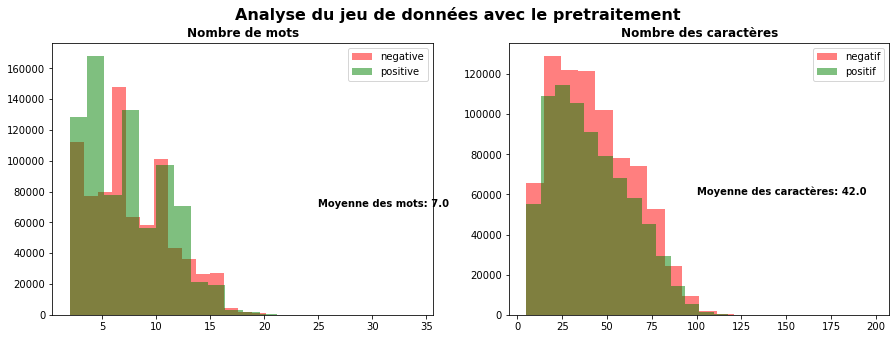

In [51]:
# Assigne les mots négatifs et positifs à une variable
mot_negatif = df[df.sentiment == 0]
mot_positif = df[df.sentiment == 1]

# Prepare plot variables
nombre_mot_negatif = mot_negatif["nombre_mot_lemma"]
nombre_mot_positif = mot_positif["nombre_mot_lemma"]
nombre_caractere_negatif = mot_negatif["nombre_caractere_lemma"]
nombre_caractere_positif = mot_positif["nombre_caractere_lemma"]

print('Min mot: {}, Max mot: {}'.format(min_mot, max_mot))
print('Min caractere: {}, Max caractere: {}'.format(min_caractere, max_caractere))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(nombre_mot_negatif, bins=20, label='negative', color='r', alpha=0.5)
ax1.hist(nombre_mot_positif, bins=20, label='positive', color='g', alpha=0.5)
ax1.set_title('Nombre de mots', fontsize=12, fontweight='bold')
message1 = 'Moyenne des mots: {}'.format(round(moyenne_mot, 0))
ax1.text(25, 70000, message1, weight='bold')
ax1.legend()

ax2.hist(nombre_caractere_negatif, bins=20, label='negatif', color='r', alpha=0.5)
ax2.hist(nombre_caractere_positif, bins=20, label='positif', color='g', alpha=0.5)
ax2.set_title('Nombre des caractères', fontsize=12, fontweight='bold')
message2 = 'Moyenne des caractères: {}'.format(round(moyenne_caractere, 0))
ax2.text(100, 60000, message2, weight='bold')
ax2.legend()

plt.suptitle('Analyse du jeu de données avec le pretraitement',
             fontsize=16, fontweight='bold')
plt.show()

In [52]:
# Supprimons la colonne inutile sur le nombre de caractère
df.drop(columns=['nombre_caractere_lemma'], inplace=True)

In [53]:
df.head()

,sentiment,id,user,tweet,tweet_traite,nombre_mot_traite,tweet_pas_stopwords,tweet_lemma,nombre_mot_lemma
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda g...",user url w that is a bummer you should got david carr of third day to d...,19,user url w bummer got david carr third day,user url bummer get david carr third day,8.0
1,0,1467810672,scotthamilton,is upset that he can't update his Facebook by texting it... and might cry as...,is upset that he cannot update his facebook by texting it and might cry a...,20,upset cannot update facebook texting cry result school today also,upset can not update facebook texting cry result school today also,11.0
2,0,1467810917,mattycus,@Kenichan I dived many times for the ball. Managed to save 50% The rest go ...,user i dived many times for the ball managed to save the rest go out o...,17,user dived many times ball managed save rest go bounds,user dive many time ball manage save rest go bound,10.0
3,0,1467811184,ElleCTF,my whole body feels itchy and like its on fire,my whole body feels itchy and like it is on fire,11,whole body feels itchy like fire,whole body feel itchy like fire,6.0
4,0,1467811193,Karoli,"@nationwideclass no, it's not behaving at all. i'm mad. why am i here? becau...",user no it is not behaving at all i am mad why am i here because i canno...,23,user no not behaving mad cannot see,user no not behave mad can not see,8.0


# Visualisation

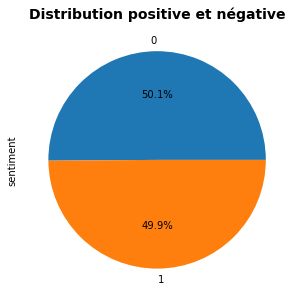

0    781488
1    778072
Name: sentiment, dtype: int64


In [54]:
# Trace la dictribution des tweet négatife et positif
plt.figure(figsize=(8,5))

df['sentiment'].value_counts().plot(kind='pie',
                                 # Chiffre après la virgule
                                 autopct='%1.1f%%')
plt.title('Distribution positive et négative',
          fontsize=14, fontweight='bold')
plt.show()

print(df["sentiment"].value_counts())

Nous allons rééquilibrer en supprimant une nouvelle fois des tweet négatifs aléatoire.

In [55]:
negatif = list(df["sentiment"].value_counts())[0]
positif = list(df["sentiment"].value_counts())[1]

In [56]:
# Sentiment positif moins sentiment négatifs
difference = negatif - positif
# Prends des lignes positives aléatoirement
df_sentiment = df[df['sentiment'] == 0].sample(difference)
liste_sentiment = list(df_sentiment.index)

In [57]:
# Réaffecte la dataframme sans les lignes choisies aléatoirement
df = df[~df.index.isin(liste_sentiment)]
df["sentiment"].value_counts()

0    778072
1    778072
Name: sentiment, dtype: int64

In [58]:
df.head(1)

,sentiment,id,user,tweet,tweet_traite,nombre_mot_traite,tweet_pas_stopwords,tweet_lemma,nombre_mot_lemma
0,0,1467810369,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda g...",user url w that is a bummer you should got david carr of third day to d...,19,user url w bummer got david carr third day,user url bummer get david carr third day,8.0


## Wordcloud

### Avec premier traitement

Nous allons séparer les tweets positifs et les tweet négatifs.

In [59]:
mot_negatif = df[df.sentiment == 0]
mot_positif = df[df.sentiment == 1]

In [60]:
tous_tweet = str(df['tweet_traite'].values)
tweet_negatif = str(mot_negatif['tweet_traite'].values)
tweet_positif = str(mot_positif['tweet_traite'].values)

# Instanciation de WordCloud
wc_tous = WordCloud(width=600, height=600, background_color="white",
                   max_words=200, stopwords=STOPWORDS, max_font_size=90,
                   collocations=False, random_state=42).generate(tous_tweet)

wc_negatif = WordCloud(width=600, height=600, background_color="white",
                   max_words=200, stopwords=STOPWORDS, max_font_size=90,
                   collocations=False, random_state=42).generate(tweet_negatif)

wc_positif = WordCloud(width=600, height=600, background_color="white",
                   max_words=200, stopwords=STOPWORDS, max_font_size=90,
                   collocations=False, random_state=42).generate(tweet_positif)

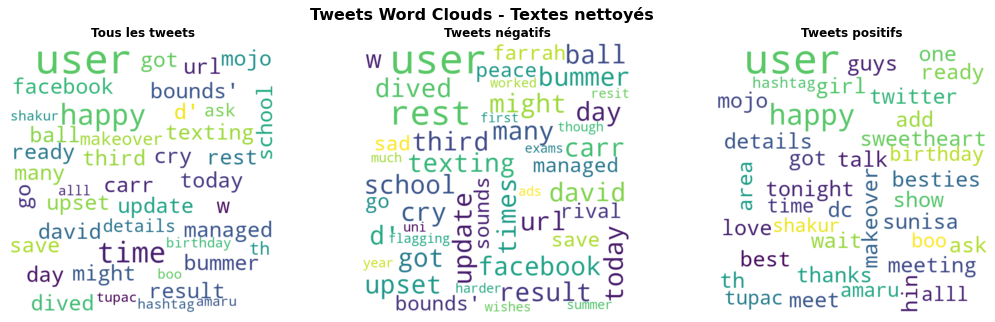

In [61]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.imshow(wc_tous, interpolation='bilinear')
ax1.set_title('Tous les tweets', fontsize=12, fontweight='bold')
ax1.axis('off')

ax2.imshow(wc_negatif, interpolation='bilinear')
ax2.set_title('Tweets négatifs', fontsize=12, fontweight='bold')
ax2.axis('off')

ax3.imshow(wc_positif, interpolation='bilinear')
ax3.set_title('Tweets positifs', fontsize=12, fontweight='bold')
ax3.axis('off')

plt.suptitle('Tweets Word Clouds - Textes nettoyés', fontsize=16, fontweight='bold')
plt.show()

### Avec lemmatisation

In [62]:
tous_tweet = str(df['tweet_lemma'].values)
tweet_negatif = str(mot_negatif['tweet_lemma'].values)
tweet_positif = str(mot_positif['tweet_lemma'].values)

# Instanciation de WordCloud
wc_tous = WordCloud(width=600, height=600, background_color="white",
                   max_words=200, stopwords=STOPWORDS, max_font_size=90,
                   collocations=False, random_state=42).generate(tous_tweet)

wc_negatif = WordCloud(width=600, height=600, background_color="white",
                   max_words=200, stopwords=STOPWORDS, max_font_size=90,
                   collocations=False, random_state=42).generate(tweet_negatif)

wc_positif = WordCloud(width=600, height=600, background_color="white",
                   max_words=200, stopwords=STOPWORDS, max_font_size=90,
                   collocations=False, random_state=42).generate(tweet_positif)

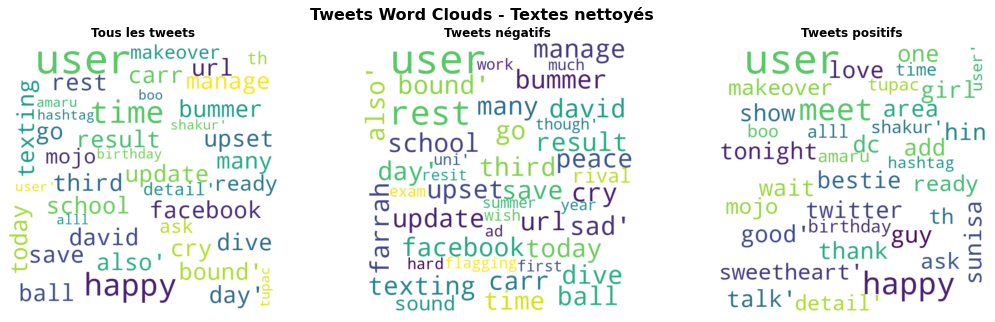

In [63]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

ax1.imshow(wc_tous, interpolation='bilinear')
ax1.set_title('Tous les tweets', fontsize=12, fontweight='bold')
ax1.axis('off')

ax2.imshow(wc_negatif, interpolation='bilinear')
ax2.set_title('Tweets négatifs', fontsize=12, fontweight='bold')
ax2.axis('off')

ax3.imshow(wc_positif, interpolation='bilinear')
ax3.set_title('Tweets positifs', fontsize=12, fontweight='bold')
ax3.axis('off')

plt.suptitle('Tweets Word Clouds - Textes nettoyés', fontsize=16, fontweight='bold')
plt.show()

## Fréquence

### Avec premier traitement

Nous allons maintenant regarder la fréquence de chaque mot pour les tweets avec le premier traitement, et avec les tweets traités avec la suppression des stopwrods, la lemmatisation etc.

In [66]:
# Créer une liste vide de chaînes de caractères
mots = ''

# Place chaque mot de chaque tweet dans la liste "mots"
for i in df["tweet_traite"].values:
    mots += i
print('Nombre de mots', len(mots))

# 'mots.split()' split chaque mot de la chaine de caractère.
# 'most_common(50)'' récupère les 50 mots les plus courant
mots_frequence = pd.DataFrame(Counter(mots.split()).most_common(50), columns=['mot', 'frequence'])
mots_frequence[:10]

Nombre de mots 109587348


,mot,frequence
0,i,990328
1,user,701193
2,to,611302
3,the,520768
4,is,424268
5,a,378124
6,you,364041
7,it,343756
8,my,311072
9,and,299930


Visulation maintenant notre dataframe à l'aide d'un graphique.

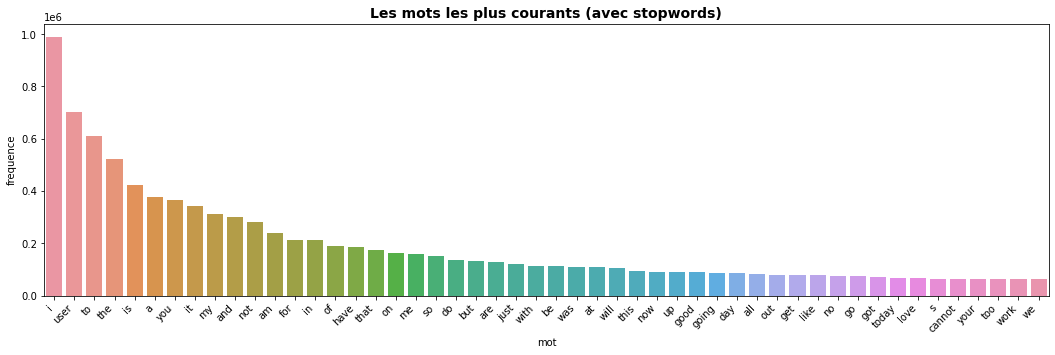

In [69]:
plt.figure(figsize=(18, 5))
sns.barplot(x=mots_frequence.mot, y=mots_frequence.frequence)
plt.xticks(rotation=45, ha='right')
plt.title('Les mots les plus courants (avec stopwords)', fontsize=14, fontweight='bold')
plt.show()

Nous pouvons voir que nous avons des mots très peu informatifs comme to, it, my, of, in etc.
"I" a même plus de 900 000 occurrences.

Il est claire que nous allons utilisé les tweets avec le traitement complet comprenant la lemmatisation.

Voyons du côté des tweet lemmatisés.

### Avec lemmatisation

In [70]:
# Créer une liste vide de chaînes de caractères
mots = ''

# Place chaque mot de chaque tweet dans la liste "mots"
for i in df["tweet_lemma"].values:
    mots += i
print('Nombre de mots', len(mots))

# 'mots.split()' split chaque mot de la chaine de caractère.
# 'most_common(50)'' récupère les 50 mots les plus courant
mots_frequence = pd.DataFrame(Counter(mots.split()).most_common(50), columns=['mot', 'frequence'])
mots_frequence[:10]

Nombre de mots 65193195


,mot,frequence
0,not,316590
1,go,152596
2,get,149699
3,user,92741
4,good,81406
5,day,78034
6,like,73351
7,no,67001
8,work,59028
9,want,58612


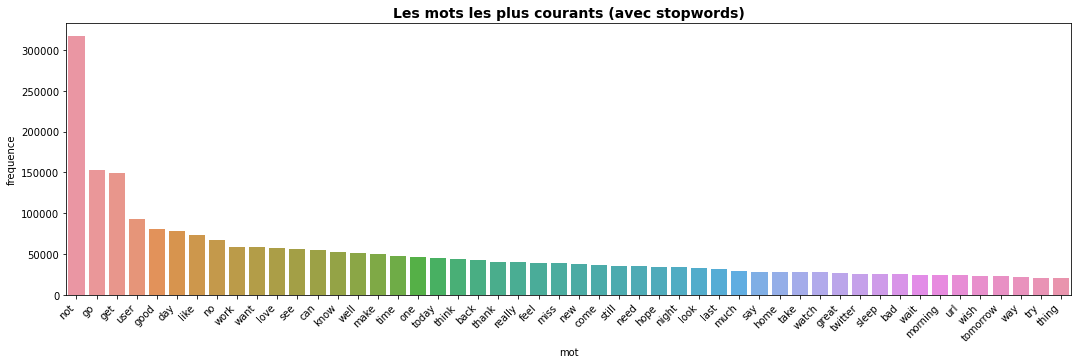

In [71]:
plt.figure(figsize=(18, 5))
sns.barplot(x=mots_frequence.mot, y=mots_frequence.frequence)
plt.xticks(rotation=45, ha='right')
plt.title('Les mots les plus courants (avec stopwords)', fontsize=14, fontweight='bold')
plt.show()

# Conclusion

Nous avons maintenant nettoyer nos tweets, ils sont prêt pour notre prochain algorithme de machine learning.